## Checking Constrained Dynamics

In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import symd

In [5]:
symd.prepare_input(15, 2, 8, 'wp-15')

['./wp-15-00.json', './wp-15-01.json', './wp-15-02.json']

In [6]:
with open('wp-15.json') as f:
    group = json.load(f)
    projector = group['projector']

with open('wp-15-01.json') as f:
    group = json.load(f)
e = np.array(group['members'][0]).reshape(3,3)
#e = np.array([0, 0, 0, 0., 0, 0, 0, 0, 1]).reshape(3,3)
basis = np.array(projector).reshape(4,4) @ np.array([50,0,0,50])
basis = basis.reshape(2,2)
#basis = np.eye(2)
ib = np.linalg.inv(basis)
print(e)
print(ib)
print(basis)
print(ib @ basis)

[[0.         0.         0.66666667]
 [0.         0.         0.33333333]
 [0.         0.         1.        ]]
[[0.01       0.0057735 ]
 [0.         0.01154701]]
[[100.      -50.     ]
 [  0.       86.60254]]
[[ 1.00000000e+00 -3.54762537e-17]
 [ 0.00000000e+00  1.00000000e+00]]


In [15]:
def project(projector, basis):
    return np.array(projector).reshape(4,4) @ basis.flatten()
basis = np.array([50, 0, 0, 50])
project(projector, basis), project(projector, project(projector, basis))

(array([100.     , -50.     ,   0.     ,  86.60254]),
 array([136.60254   , -68.30127   ,   0.        , 118.30126934]))

In [125]:
def scale(x, ib=ib):
    s = ib @ x
    return np.fmod(s, 1.0)
def unscale(x, basis=basis):
    return  basis @ x
x = np.array([0.5, 0.5])
print(x)
print(unscale(x))
print(scale(unscale(x)))

[0.5 0.5]
[25.      43.30127]
[0.5 0.5]


In [4]:
def pa(x, e=e):
    return (e @ (np.concatenate((x, [1])).T))[:2]
pa(x)

array([0.66666667, 0.33333333])

In [5]:
# compute A matrix
N = 2
A = np.zeros((N, N))
ibt = ib
grad = e[:-1,:-1] @ ibt - ibt
print('grad', grad)
print(A)
A = grad @ grad
print(A)
Ainv = np.linalg.pinv(A)
print(Ainv)
print(Ainv @ A)
Ainv = Ainv @ grad
print(Ainv)


grad [[-0.01       -0.0057735 ]
 [ 0.         -0.01154701]]
[[0. 0.]
 [0. 0.]]
[[0.0001     0.0001244 ]
 [0.         0.00013333]]
[[ 1.00000000e+04 -9.33012700e+03]
 [-4.69659974e-13  7.49999993e+03]]
[[ 1.00000000e+00  2.66448033e-16]
 [-4.69659974e-17  1.00000000e+00]]
[[-1.00000000e+02  5.00000000e+01]
 [ 4.69659974e-15 -8.66025400e+01]]


In [6]:
def step(x, v, f, dt, gamma=0.05, T = 0.2):
    # b
    #v += f(x) * dt / 2
    # a 
    x += v * dt / 2
    # constraint 1
    s = scale(x)
    delta = pa(s) - s
    print('delta:', delta, 's', s, 'x', x)
    l = Ainv @ delta.T
    print('lambda', l)    
    v -= l / dt * 2
    x -= l
    s = scale(x)
    delta = pa(s) - s
    print('after delta:', delta, 's', s, 'x', x)
    # o
    c1 = np.exp(-gamma * dt)
    c2 = np.sqrt(1 - c1**2)
    v *= c1
    v += c2 * np.random.normal() * np.sqrt(T)
    # a 
    x += dt * v / 2    
    # constraint 2
    s = scale(x)
    delta = pa(s) - s
    print('delta:', delta, 's', s, 'x', x)
    l = Ainv @ delta.T
    print('A lambda', A @ l)    
    v -= l / dt * 2
    x -= l
    s = scale(x)
    delta = pa(s) - s
    print('after delta:', delta, 's', s, 'x', x)
    # b
    v += f(x) * dt / 2
    return x,v
x = np.array([0.376419008701368, 0.008526634164955138], dtype=float)
x = unscale(x)
f = lambda x: -2 * np.sqrt(np.sum(x**2)) * x
v = np.array([0.5, 1], dtype=float)
N = 5
traj = np.empty((N, 2), dtype=float)
vtraj = np.empty((N, 2), dtype=float)
for i in range(N):
    traj[i,:] = x
    vtraj[i,:] = v
    x,v = step(x, v, f, 0.05)    
    print(x)

delta: [0.28997832 0.32451802] s [0.37668835 0.00881531] x [37.22806916  0.76342818]
lambda [-12.77193134 -28.10408487]
after delta: [0.00000000e+00 1.66533454e-16] s [0.66666667 0.33333333] x [50.0000005  28.86751304]
delta: [-0.28954898 -0.32401475] s [0.95621565 0.65734808] x [62.7541609  56.92801325]
A lambda [0.00476619 0.0037414 ]
after delta: [-1.11022302e-16 -1.66533454e-16] s [0.66666667 0.33333333] x [50.0000005  28.86751304]
[50.0000005  28.86751304]
delta: [0.04811252 0.02405626] s [0.61855415 0.30927707] x [46.39156127 26.78417973]
lambda [-3.60843923 -2.08333331]
after delta: [0.00000000e+00 5.55111512e-17] s [0.66666667 0.33333333] x [50.0000005  28.86751304]
delta: [-7.10947085e-06 -5.20449389e-06] s [0.66667378 0.33333853] x [50.00045122 28.86796377]
A lambda [1.01142868e-07 6.00963192e-08]
after delta: [0. 0.] s [0.66666667 0.33333333] x [50.0000005  28.86751304]
[50.0000005  28.86751304]
delta: [0.04811252 0.02405626] s [0.61855415 0.30927707] x [46.39156127 26.78417

(36.576347594983496,
 50.63922206690555,
 -0.6680260670802219,
 30.273967288074324)

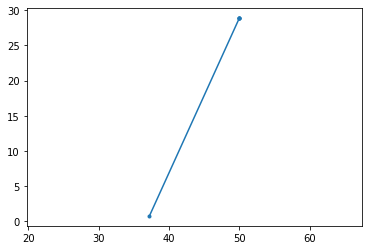

In [7]:
plt.plot(traj[:,0], traj[:,1], '.-')
# for i in range(N):
#     xi = traj[i]
#     vi = vtraj[i]
#     vi /= np.linalg.norm(vi) / 0.2
#     plt.plot([xi[0], xi[0] + vi[0]], [xi[1], xi[1] + vi[1]], '-', color='C1')
plt.gca().axis('equal')

In [8]:
traj

array([[37.21556916,  0.73842818],
       [50.0000005 , 28.86751304],
       [50.0000005 , 28.86751304],
       [50.0000005 , 28.86751304],
       [50.0000005 , 28.86751304]])

## Checking Symmetry of Proposal Distribution

In [51]:
sign = lambda x: bool(x > 0) - bool(x < 0)

def levi_civta(index):
    p = 1
    d = len(index)
    for i in range(d):
        for j in range(i + 1, d):
            p *= sign(index[j] - index[i])
    return p

def rvolume(b, v, i, index):
    d = len(index)
    if i == d:
        return levi_civta(index) * v
    vi = 0
    for j in range(d):
        index[i] = j
        vi += rvolume(b, b[j][i] * v, i + 1, index)
    return vi

def volume(b): 
    index = [0] * len(b)
    return rvolume(b, 1, 0, index)

In [121]:
def proj(ub):
    fub = ub.flatten()
    fb = np.array(projector).reshape(4,4) @ fub
    return fb.reshape(2,2)
vi = []
vj = []
for i in range(10000):
    ub = np.array([[1,0],[0,1]]) + np.random.normal(size=(2,2)) * 0.1
    vi.append(volume(proj(ub)))
    ub *= (1 + 0.01 - np.random.uniform(size=4) * 0.02).reshape(2,2)
    vj.append(volume(proj(ub)))
vi,vj = np.array(vi), np.array(vj)


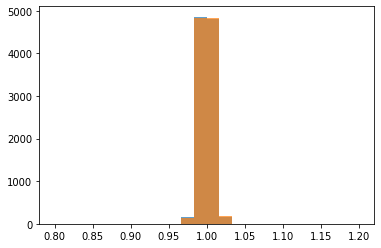

In [122]:
plt.hist(vj / vi, bins=np.linspace(0.8,1.2,25), alpha=0.7)
plt.hist(vi / vj, bins=np.linspace(0.8,1.2,25), alpha=0.7)
plt.show()

In [123]:
np.mean(vj / vi), np.mean(vi / vj)

(0.9999481774367357, 1.0001209241280775)

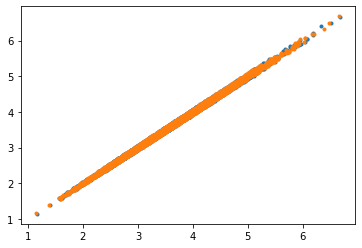

In [124]:
plt.plot(vj, vi, '.')
plt.plot(vi, vj, '.')

## Reflection

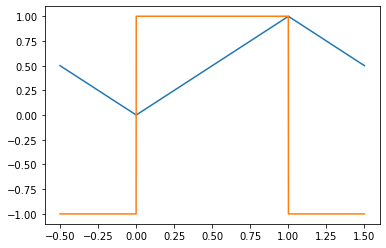

In [46]:
def triangle_wave(x):
    #return 2 * np.abs(np.abs(np.fmod(x + 0.5, 1.)) - 1/2)
    return 2 * np.abs(x/2 - np.floor(x/2 + 1/2))
    #return np.fmod(x, 1.0)
def square_wave(x):
    return 2 * (2 * np.floor(x / 2) - np.floor(x)) + 1
x = np.linspace(-.5,1.5,10000)
plt.plot(x, triangle_wave(x))
plt.plot(x, square_wave(x))
#plt.ylim(0,1)

In [44]:
triangle_wave(0.4)

0.4